This notebook provides examples to go along with the [textbook](https://underactuated.csail.mit.edu/contact.html).  I recommend having both windows open, side-by-side!


In [1]:
import numpy as np
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    ModelVisualizer,
    Parser,
    Simulator,
    StartMeshcat,
    namedview,
    DirectCollocation,
    FrameIndex,
    MultibodyPlant,
    SceneGraph,
    PiecewisePolynomial,
    Solve,
    SnoptSolver,
    TrajectorySource,
    MultibodyPositionToGeometryPose,
    PlanarSceneGraphVisualizer,
    SpatialForce,
    ExternallyAppliedSpatialForce,
    RotationMatrix,
    Quaternion,
    TemplateSystem,
    LeafSystem_,
    SpatialInertia,
    UnitInertia,
    RigidTransform,
    RevoluteJoint,
    FixedOffsetFrame,
    Context,
    ContinuousState,
    ForceElement,
    RollPitchYaw,
    Propeller,
    PropellerInfo
)
import pydrake

#from underactuated import running_as_notebook
from underactuated import ConfigureParser, running_as_notebook
from underactuated.jupyter import AdvanceToAndVisualize

In [2]:
meshcat = StartMeshcat()

model_urdf_file = open('model2.urdf', 'r')
model_urdf = model_urdf_file.read()
model_urdf = '<?xml version="1.0"?> <robot name="Sk8t3rBot"><link name="rink">     <origin xyz="0 0 0" />    <visual>        <geometry>            <box size="100 100 0.0001" />        </geometry>        <material>            <color rgba="0.86 0.945 0.98 1" />        </material>    </visual></link><joint name="rink_world" type="fixed">    <parent link="world" />    <child link="rink" /></joint><link name="body"><inertial>     <origin xyz="0 0 0.25" />     <mass value="50" />     <inertia ixx="1.1354166666666665"  ixy="0"  ixz="0" iyy="2.083333333333333" iyz="0" izz="1.1354166666666665" /> </inertial><visual> <origin xyz="0 0 0.25" /> <origin xyz="0 0 0.25" /> <geometry> <box size="0.5 0.15 0.5" /> </geometry> <material> <color rgba="0 1 0 1" /></material> </visual></link><link name="inner_hip" /> <joint name="inner_hip_joint" type="continuous">     <origin xyz="0 0 0" />     <parent link="inner_hip" />     <child link="body" />     <axis xyz="0 0 1" /> </joint> <transmission>     <joint name="inner_hip_joint" />     <actuator name="inner_hip_act" />     <type>transmission_interface/SimpleTransmission</type> </transmission><link name="hip" /> <joint name="hip_joint" type="continuous">     <origin xyz="0 0 0" />     <parent link="hip" />     <child link="inner_hip" />     <axis xyz="0 1 0" /> </joint> <transmission>     <joint name="hip_joint" />     <actuator name="hip_act" />     <type>transmission_interface/SimpleTransmission</type> </transmission><link name="upper_leg">     <inertial>         <origin xyz="0 0 0.1" />         <mass value="10" />         <inertia ixx="0.05208333333333333"  ixy="0"  ixz="0" iyy="0.06666666666666668" iyz="0" izz="0.05208333333333333" />     </inertial>     <visual>         <origin xyz="0 0 0.1" />         <geometry> <box size="0.2 0.15 0.2" /> </geometry>         <material> <color rgba="1 0 0 1" /></material>     </visual> </link> <joint name="phi" type="continuous">     <origin xyz="0 0 0.2" />     <parent link="upper_leg" />     <child link="hip" />     <axis xyz="1 0 0" /> </joint> <transmission>     <joint name="phi" />     <actuator name="phi_act" />     <type>transmission_interface/SimpleTransmission</type> </transmission><link name="lower_leg">     <inertial>         <origin xyz="0 0 0.1" />         <mass value="10" />         <inertia ixx="0.05208333333333333"  ixy="0"  ixz="0" iyy="0.06666666666666668" iyz="0" izz="0.05208333333333333" />     </inertial>     <visual>         <origin xyz="0 0 0.1" />         <geometry> <box size="0.2 0.15 0.2" /> </geometry>         <material> <color rgba="0 0 1 1" /></material>     </visual> </link> <joint name="knee" type="continuous">     <origin xyz="0 0 0.2" />     <parent link="lower_leg" />     <child link="upper_leg" />     <axis xyz="1 0 0" /> </joint> <transmission>     <joint name="knee" />     <actuator name="knee_act" />     <type>transmission_interface/SimpleTransmission</type> </transmission><link name="blade">     <inertial>         <mass value="2" />,         <inertia ixx="0.027083333333333338"  ixy="0"  ixz="0" iyy="0.00043333333333333337" iyz="0" izz="0.026683333333333337" />,     </inertial>     <visual>         <origin xyz="0 0 0.025" />         <geometry> <box size="0.01 0.4 0.05" /> </geometry>     </visual> </link> <joint name="ankle" type="continuous">     <origin xyz="0 0 0.05" />     <parent link="blade" />     <child link="lower_leg" /> </joint> <transmission>     <joint name="ankle" />     <actuator name="ankle_act" />     <type>transmission_interface/SimpleTransmission</type> </transmission></robot></xml>'

#ground_urdf = open("ground.urdf", "r").read()

"""
builder2 = DiagramBuilder()

plant2 = builder2.AddSystem(MultibodyPlant(time_step=0.0))
scene_graph2 = builder2.AddSystem(SceneGraph())
parser = Parser(plant2, scene_graph2)
ConfigureParser(parser)
parser.AddModelsFromString(model_urdf, "urdf")
"""
visualizer = ModelVisualizer(meshcat=meshcat)
visualizer.parser().AddModelsFromString(model_urdf, "urdf")
visualizer.Run(loop_once=not running_as_notebook)
meshcat.Delete()
#meshcat.DeleteAddedControls()


INFO:drake:Meshcat listening for connections at https://6a0b295f-cf18-4bda-b186-efbdae810fad.deepnoteproject.com/7000/


INFO:drake:Click 'Stop Running' or press Esc to quit


In [3]:
BODY_HEIGHT = 0.5
BODY_WIDTH = 0.5
BODY_DEPTH = 0.15
BODY_MASS = 50

UPPER_LEG_HEIGHT = 0.2
UPPER_LEG_WIDTH = 0.2
UPPER_LEG_DEPTH = 0.15
UPPER_LEG_MASS = 10

LOWER_LEG_HEIGHT = 0.2
LOWER_LEG_WIDTH = 0.2
LOWER_LEG_DEPTH = 0.15
LOWER_LEG_MASS = 10

BLADE_HEIGHT = 0.05
BLADE_WIDTH = 0.01
BLADE_LENGTH = 0.4
BLADE_MASS = 2

In [4]:
NUM_STATES = 23
NUM_INPUTS = 5
NUM_FORCES = 4




SHIFT = int((NUM_STATES-1)/2)
X = 4
Y = 5
Z = 6
ANKLE = 7
KNEE = 8
QUAD = 9
HIP = 10
INNER_HIP = 11
# 17 v/s (23-1)/2 + 6 = 22/2 + 6 = 11+6 = 17

X_DOT = SHIFT + X
Y_DOT = SHIFT + Y
Z_DOT = SHIFT + Z



def inertia(m, lx, ly, lz):
    return SpatialInertia(
        m,
        np.array([0, 0, 0]),
        UnitInertia(
            1/12 * (ly**2 + lz**2),
            1/12 * (lx**2 + lz**2),
            1/12 * (lx**2 + ly**2)
        ),
        False
    )

class SkateForce(ForceElement):
    def __init__(self):
        super().__init__()
    
    def DoCalcAndAddForceContribution(self, context, pc, vc, forces):
        state_vec = context.get_continuous_state().get_vector()

        """
        # find the time derivative of dummy plant
        self.plant.DoCalcTimeDerivatives(context, self.plant_derivs)
        derivs_vec = self.plant_derivs.get_vector()
        print("c")
        """
        #MultibodyPlant.DoCalcTimeDerivatives(self, context, derivatives)

        state_vec = context.get_continuous_state().get_vector()
        derivs_vec = derivatives.get_vector()

        vx = state_vec[X_DOT]
        vy = state_vec[Y_DOT]
        vz = state_vec[Z_DOT]

        v = np.array([vx, vy, vz])



        F_Bo_W_array = forces.mutable_body_forces();

        model = self.get_parent_tree()
        num_bodies = model.num_bodies()

        for body_index in range(num_bodies):
            body = model.get_body(body_index)

            if body.name() == "blade":
                mass = body.get_mass(context)
                mobod_index = body.mobod_index()



                p_BoBcm_B = body.CalcCenterOfMassInBodyFrame(context)
                R_WB = pc.get_R_WB(mobod_index)
                p_BoBcm_W = np.matmul(R_WB, p_BoBcm_B)

                # get current applied force without reactive forces, to get the unaltered acc
                a = F_Bo_W_array[mobod_index] / mass
                ax = derivs_vec[X_DOT]
                ay = derivs_vec[Y_DOT]
                az = derivs_vec[Z_DOT]

                a = np.array([ax, ay, az])

                qr = state_vec[0]
                qi = state_vec[1]
                qj = state_vec[2]
                qk = state_vec[3]

                R = np.array([
                    [1-2*(qj**2 + qk**2), 2*(qi*qj - qk*qr), 2*(qi*qk + qj*qr)],
                    [2*(qi*qj + qk*qr), 1-2*(qi**2 + qk**2), 2*(qj*qk - qi*qr)],
                    [2*(qi*qk - qj*qr), 2*(qj*qk + qi*qr), 1-2*(qi**2 + qj**2)],
                ])

                f_dir = np.matmul(R, np.array([0, 1, 0]))
                s_dir = np.matmul(R, np.array([1, 0, 0]))
                n_dir = np.matmul(R, np.array([0, 0, 1]))

                BLADE_MASS = 2

                F_fwd  = -np.dot(BLADE_MASS * a, n_dir)
                F_back = -0.01 * np.dot(v, f_dir)
                F_side = -0.1  * np.dot(v, s_dir)

                F_app = F_fwd * n_dir + F_back * f_dir + F_side * s_dir

                F_Bo_W = SpatialForce(p_BoBcm_W.cross(F_app), F_app)
                F_Bo_W_array[mobod_index] += F_Bo_W;




def addBlade(plant, mdl_inst):
    return plant.AddRigidBody(
        "blade",
        mdl_inst,
        inertia(
            BLADE_MASS, BLADE_WIDTH, BLADE_LENGTH, BLADE_HEIGHT
        )
    )

def addLowerLeg(plant, mdl_inst):
    return plant.AddRigidBody(
        "lower_leg",
        mdl_inst,
        inertia(
            LOWER_LEG_MASS, LOWER_LEG_WIDTH, LOWER_LEG_DEPTH, LOWER_LEG_HEIGHT
        )
    )

def addUpperLeg(plant, mdl_inst):
    return plant.AddRigidBody(
        "upper_leg",
        mdl_inst,
        inertia(
            UPPER_LEG_MASS, UPPER_LEG_WIDTH, UPPER_LEG_DEPTH, UPPER_LEG_HEIGHT
        )
    )

def addHip(plant, mdl_inst):
    return plant.AddRigidBody(
        "hip",
        mdl_inst,
        inertia(
            0.1,0,0,0
        )
    )

def addInnerHip(plant, mdl_inst):
    return plant.AddRigidBody(
        "inner_hip",
        mdl_inst,
        inertia(
            0.1,0,0,0
        )
    )

def addBody(plant, mdl_inst):
    return plant.AddRigidBody(
        "body",
        mdl_inst,
        inertia(
            BODY_MASS, BODY_WIDTH, BODY_DEPTH, BODY_HEIGHT
        )
    )



def addAnkle(plant, blade, lower_leg):
    ankle_frame = plant.AddFrame(
        FixedOffsetFrame(
            "top_of_blade",
            blade.body_frame(),
            RigidTransform(
                np.array([0, 0, BLADE_HEIGHT])
            )
        ),
    )

    ankle = RevoluteJoint(
        "ankle",
        ankle_frame,
        #self.blade.body_frame().CalcOffsetPoseInBody(
        #    self.context,
        #    np.array([0, 0, BLADE_HEIGHT])
        #),
        lower_leg.body_frame(),
        np.array([1, 0, 0])
    )
    plant.AddJoint(ankle)
    plant.AddJointActuator("ankle_act", ankle)

def addKnee(plant, lower_leg, upper_leg):
    knee_frame = plant.AddFrame(
        FixedOffsetFrame(
            "knee_frame",
            lower_leg.body_frame(),
            RigidTransform(
                np.array([0, 0, LOWER_LEG_HEIGHT])
            )
        )
    )

    knee = RevoluteJoint(
        "knee",
        knee_frame,
        upper_leg.body_frame(),
        np.array([1, 0, 0])
    )
    plant.AddJoint(knee)
    plant.AddJointActuator("knee_act", knee)

def addQuad(plant, upper_leg, hip):
    phi_frame = plant.AddFrame(
        FixedOffsetFrame(
            "phi_frame",
            upper_leg.body_frame(),
            RigidTransform(
                np.array([0, 0, UPPER_LEG_HEIGHT])
            )
        )
    )

    quad = RevoluteJoint(
        "phi",
        phi_frame,
        hip.body_frame(),
        np.array([1, 0, 0])
    )
    plant.AddJoint(quad)
    plant.AddJointActuator("phi_act", quad)

def addHipExtendor(plant, hip, inner_hip):
    jt = RevoluteJoint(
        "hip_joint",
        hip.body_frame(),
        inner_hip.body_frame(),
        np.array([0, 1, 0])
    )
    plant.AddJoint(jt)
    plant.AddJointActuator("hip_act", jt)

def addInnerHipFlexor(plant, inner_hip, body):
    jt = RevoluteJoint(
        "inner_hip_joint",
        inner_hip.body_frame(),
        body.body_frame(),
        np.array([0, 0, 1])
    )
    plant.AddJoint(jt)
    plant.AddJointActuator("theta_act", jt)



class Sk8t3rPlant(MultibodyPlant):
    def __init__(self):
        super().__init__(0.0)
        # torques on hip, quad, knee, and ankle
        #self.DeclareVectorInputPort("input", NUM_INPUTS)
        #self.DeclareContinuousState(NUM_STATES)
        #self.DeclareVectorOutputPort("state", NUM_STATES, self.CopyStateOut)

    

        

        #self.AddForceElement(SkateForce())#self.model_instance))

        #self.Finalize()

        #self.context = self.CreateDefaultContext()

        #self.derivs = self.AllocateTimeDerivatives()
        #self.DoCalcTimeDerivatives(self.context, self.EvalTimeDerivatives(self.context))

        

        #self.plant = plant
        #self.plant_derivs = plant.AllocateTimeDerivatives()
        #self.plant_context = plant.CreateDefaultContext()

        #builder.AddSystem(self)
        #builder.Connect(self.)

    
    

    

    

    def CopyStateOut(self, context, output):
        x = context.get_continuous_state_vector().CopyToVector()
        output.SetFromVector(x),

In [5]:
builder = DiagramBuilder()


plant = MultibodyPlant(0.0)
model_instance = plant.AddModelInstance("sk8t3r_bot")

blade     = addBlade   (plant, model_instance)
lower_leg = addLowerLeg(plant, model_instance)
upper_leg = addUpperLeg(plant, model_instance)
hip       = addHip     (plant, model_instance)
inner_hip = addInnerHip(plant, model_instance)
body      = addBody    (plant, model_instance)

ankle            = addAnkle         (plant, blade,     lower_leg)
knee             = addKnee          (plant, lower_leg, upper_leg)
quad             = addQuad          (plant, upper_leg, hip)
hip_extendor     = addHipExtendor   (plant, hip,       inner_hip)
inner_hip_flexor = addInnerHipFlexor(plant, inner_hip, body)

builder.AddSystem(plant)
plant.Finalize()
"""
plant = builder.AddSystem(MultibodyPlant(0.0))
parser = Parser(plant, scene_graph2)
ConfigureParser(parser)
parser.AddModelsFromString(model_urdf, "urdf")
plant.Finalize()
context = plant.CreateDefaultContext()
"""





from pydrake.all import LeafSystem
# Define a system with an input port
@TemplateSystem.define("InputSystem_")
def InputSystem_(T):
    class Impl(LeafSystem_[T]):
        def _construct(self, converter=None):
            LeafSystem_[T].__init__(self, converter)
            self.DeclareVectorInputPort("input_port", 8)

            self.DeclareVectorOutputPort("reaction",  3, self.CalcFriction)
            self.DeclareVectorOutputPort("actuation", 5, self.CalcActuation)
        def _construct_copy(self, other, converter=None):
            Impl._construct(self, converter=converter)

        def CalcFriction(self, context, output):
            inp = self.EvalVectorInput(context, 0)
            output.SetFromVector([inp[0], inp[1], inp[2]])
        def CalcActuation(self, context, output):
            inp = self.EvalVectorInput(context, 0)
            output.SetFromVector([inp[3], inp[4], inp[5], inp[6], inp[7]])
    
    return Impl


InputSystem = InputSystem_[None]  # Default instantiation

# Create a DiagramBuilder
builder2 = DiagramBuilder()

# Create an instance of the InputSystem with a specified input size



# Now we can add in propellers as an external force on the MultibodyPlant.
body_index = plant.GetBodyByName("blade").index()

# Note: Rotors 0 and 2 rotate one way and rotors 1 and 3 rotate the other.
prop_info = [
    PropellerInfo(body_index, RigidTransform(), 1, 0), # normal force
    PropellerInfo(body_index, RigidTransform(RollPitchYaw(0,0,np.pi/2),np.array([0,0,0])), 1, 0), # backwards friction
    PropellerInfo(body_index, RigidTransform(RollPitchYaw(0,np.pi/2,0),np.array([0,0,0])), 1, 0) # sideways friction
]
propellers = builder.AddSystem(Propeller(prop_info))
builder.Connect(
    propellers.get_output_port(),
    plant.get_applied_spatial_force_input_port(),
)
builder.Connect(
    plant.get_body_poses_output_port(),
    propellers.get_body_poses_input_port(),
)
"""
builder.Connect(
    plant.(),
    plant.get_actuation_input_port()
)
"""
#builder.ExportInput(propellers.get_command_input_port(), "f")
#builder.ExportInput(plant.get_actuation_input_port(), "u")

# Define your subsystems
subsystem1 = propellers  # Define your first subsystem
subsystem2 = plant  # Define your second subsystem

# Add subsystems to the builder
input_system = builder.AddSystem(InputSystem())  # Example: 2-dimensional input
#subsystem1_index = builder.AddSystem(propellers)
#subsystem2_index = builder.AddSystem(plant)

builder.Connect(input_system.get_output_port(0), subsystem1.get_command_input_port())
builder.Connect(input_system.get_output_port(1), subsystem2.get_actuation_input_port())

builder.ExportInput(input_system.get_input_port(), "u_fric")


#print(context)

#MultibodyPlant.DoCalcTimeDerivatives(sk8t3r, context)

#scene_graph = builder.AddSystem(SceneGraph())

x0 = np.zeros(23)
x0[0] = 1

#context.SetContinuousState(x0)

diagram = builder.Build()

print(diagram.get_input_port(0).size())
#print(diagram.get_input_port(1).size())
diagram_context = diagram.CreateDefaultContext()
#derivs = sk8t3r.EvalTimeDerivatives(context)

#sk8t3r.DoCalcTimeDerivatives(context, derivs)
#print(derivs.get_vector())

#print(MultibodyPlant.EvalTimeDerivatives(sk8t3r, context))
#print("--")
#print(sk8t3r.EvalTimeDerivatives(context).get_vector())

8


# Simulation

In [6]:
N = 21
dircol = DirectCollocation(
    diagram,
    diagram_context,
    num_time_samples=N,
    minimum_time_step=0.05,
    maximum_time_step=1,#,
    #input_port_index=diagram.get_input_port().get_index()#, diagram.get_input_port(1).get_index()])#sk8t3r.get_actuation_input_port().get_index(),
)
prog = dircol.prog()
dircol.AddEqualTimeIntervalsConstraints()





T = 2
ts = [0, 0.5, 1, 1.5, 2];

pi = np.pi

def get_state_nom_t(t):
    xf = np.zeros(2*plant.num_positions() - 1)
    xf[X] = 0#0.5 * np.sin(2*pi/180 * t/2)
    xf[X_DOT] = 0#0.5*2*pi/2 * np.cos(2*pi * t/2)
    xf[Y_DOT] = 0.5
    xf[Y] = 0.5 * t
    xf[0] = 1

    return xf

x0 = get_state_nom_t(0)
final_state = get_state_nom_t(2)

initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
    ts,
    np.column_stack(
        (
            get_state_nom_t(0),
            get_state_nom_t(0.5),
            get_state_nom_t(1),
            get_state_nom_t(1.5),
            final_state
        )
    )
)

dircol_input = dircol.input()
state = dircol.state()
react = dircol_input[0:3]
u     = dircol_input[3:]

x0 = dircol.initial_state()
xf = dircol.final_state()

prog.AddConstraint(x0[X] == 0)
prog.AddConstraint(x0[Y] == 0)

for i in range(23):
    if not (i == Y):
        prog.AddConstraint(x0[i] - xf[i] == 0)
        prog.AddConstraint(x0[i] - xf[i] == 0)

"""
prog.AddBoundingBoxConstraint(
    x0,
    x0,
    dircol.initial_state(),
)
"""
dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)



# blade stays tangent to ice
qr = state[0]
qi = state[1]
qj = state[2]
qk = state[3]
R = np.array([
    [1-2*(qj**2 + qk**2), 2*(qi*qj - qk*qr), 2*(qi*qk + qj*qr)],
    [2*(qi*qj + qk*qr), 1-2*(qi**2 + qk**2), 2*(qj*qk - qi*qr)],
    [2*(qi*qk - qj*qr), 2*(qj*qk + qi*qr), 1-2*(qi**2 + qj**2)],
])

blade_reaction_normal = np.matmul(R, np.array([0, 0, 1]))
blade_sideways = np.matmul(R, np.array([1, 0, 0]))
blade_forwards = np.matmul(R, np.array([0, 1, 0]))

#rot_y = R[0, 0]
dircol.AddConstraintToAllKnotPoints(blade_forwards[2] == 0)



vel = state[X_DOT:Z_DOT+1]

blade_reaction_normal = np.matmul(R, np.array([0, 0, 1]))
blade_sideways = np.matmul(R, np.array([1, 0, 0]))
blade_forwards = np.matmul(R, np.array([0, 1, 0]))

vel_forwards = np.dot(blade_forwards, vel)
vel_sideways = np.dot(blade_sideways, vel)

# no velocity along normal --> set contact force constraint
#dircol.AddConstraintToAllKnotPoints(np.dot(vel, blade_reaction_normal) == 0)
# no velocity along normal --> set contact force constraint
dircol.AddConstraintToAllKnotPoints(react[1] == -0.05 * vel_forwards)
dircol.AddConstraintToAllKnotPoints(react[2] == -10  * vel_sideways)



pi = np.pi
# actuation constraints
#dircol.AddConstraintToAllKnotPoints(u[1] <= 50*pi/180)
#dircol.AddConstraintToAllKnotPoints(u[1] >= -50*pi/180)

#dircol.AddConstraintToAllKnotPoints(u[2] <= 50*pi/180)
#dircol.AddConstraintToAllKnotPoints(u[2] >= -50*pi/180)

#dircol.AddConstraintToAllKnotPoints(u[3] <= 50*pi/180)
#dircol.AddConstraintToAllKnotPoints(u[3] >= -50*pi/180)

#dircol.AddConstraintToAllKnotPoints(u[4] <= 50*pi/180)
#dircol.AddConstraintToAllKnotPoints(u[4] >= -50*pi/180)



# ankle constraint

cos_angle_from_up = blade_reaction_normal[2]
cos_angle_from_Y  = blade_forwards[1]
dircol.AddConstraintToAllKnotPoints(cos_angle_from_up >= np.cos(45*pi/180))
dircol.AddConstraintToAllKnotPoints(cos_angle_from_Y >= np.cos(45*pi/180))

dircol.AddConstraintToAllKnotPoints(state[Z] == 0)
#dircol.AddConstraintToAllKnotPoints(state[ANKLE] <= 15*pi/180)
#dircol.AddConstraintToAllKnotPoints(state[ANKLE] >= -15*pi/180)

dircol.AddConstraintToAllKnotPoints(state[X] <= 1.5)
dircol.AddConstraintToAllKnotPoints(state[X] >= -1.5)

dircol.AddConstraintToAllKnotPoints(state[KNEE] <= 50*pi/180)
dircol.AddConstraintToAllKnotPoints(state[KNEE] >= 0)


dircol.AddConstraintToAllKnotPoints(state[QUAD] >= -15*pi/180)
dircol.AddConstraintToAllKnotPoints(state[QUAD] <= 0)

dircol.AddConstraintToAllKnotPoints(state[HIP] <= 30*pi/180)
dircol.AddConstraintToAllKnotPoints(state[HIP] >= -30*pi/180)

"""
dircol.AddConstraintToAllKnotPoints(state[INNER_HIP] <= 50*pi/180)
dircol.AddConstraintToAllKnotPoints(state[INNER_HIP] >= -50*pi/180)
"""


#dircol.AddRunningCost(np.dot(u, u))
vy = state[Y_DOT]
dircol.AddRunningCost(-vy**2)

solver = SnoptSolver()
solver_id = solver.solver_id()
major_tol = 1e-3
minor_tol = 1e-3
prog.SetSolverOption(solver_id, "Feasibility tolerance", major_tol)
prog.SetSolverOption(solver_id, "Major feasibility tolerance", major_tol)
prog.SetSolverOption(solver_id, "Major optimality tolerance", major_tol)
prog.SetSolverOption(solver_id, "Minor feasibility tolerance", minor_tol)
prog.SetSolverOption(solver_id, "Minor optimality tolerance", minor_tol)
result = Solve(prog)

assert result.is_success()

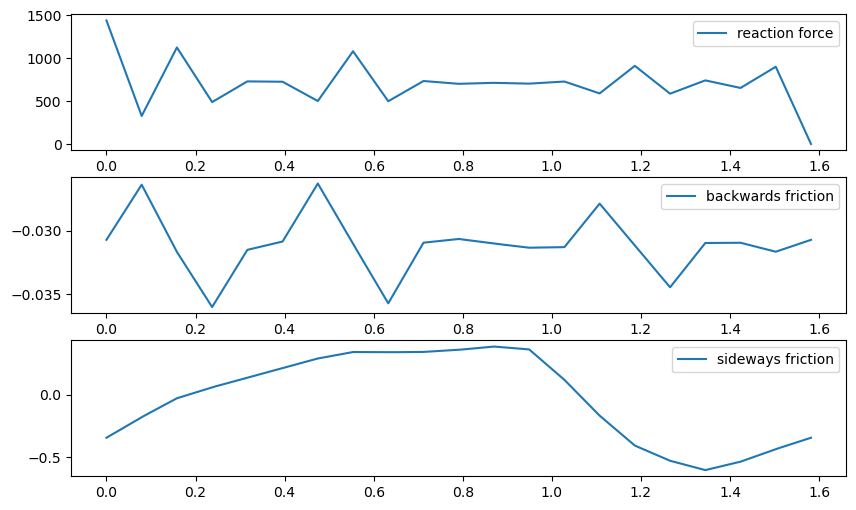

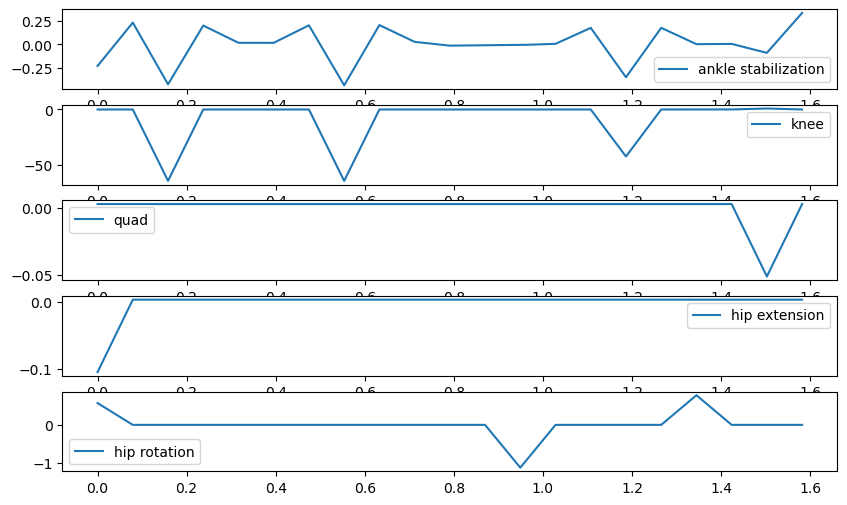

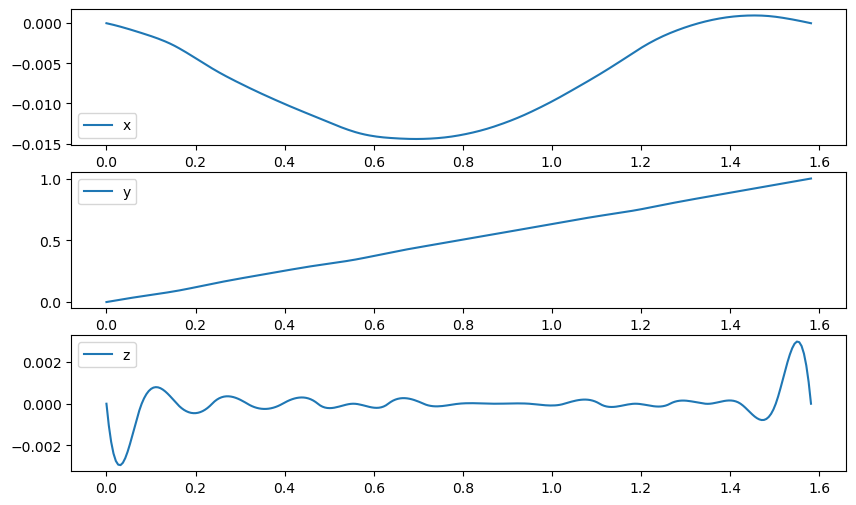

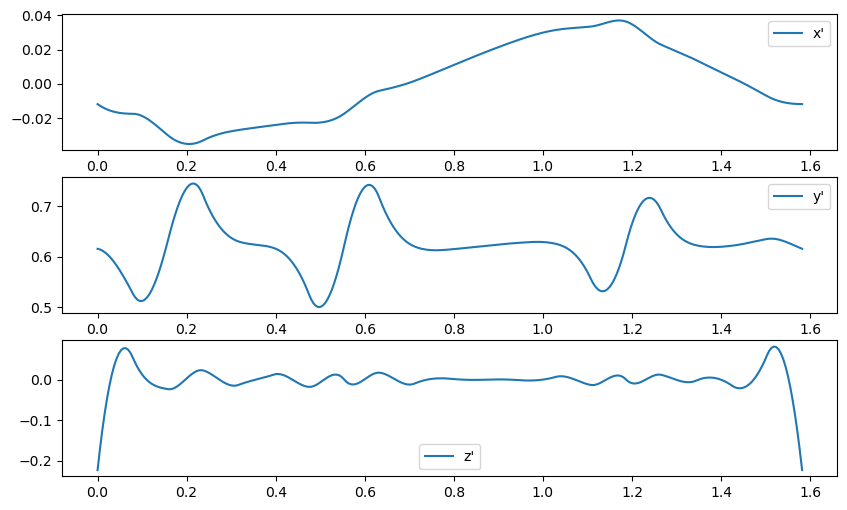

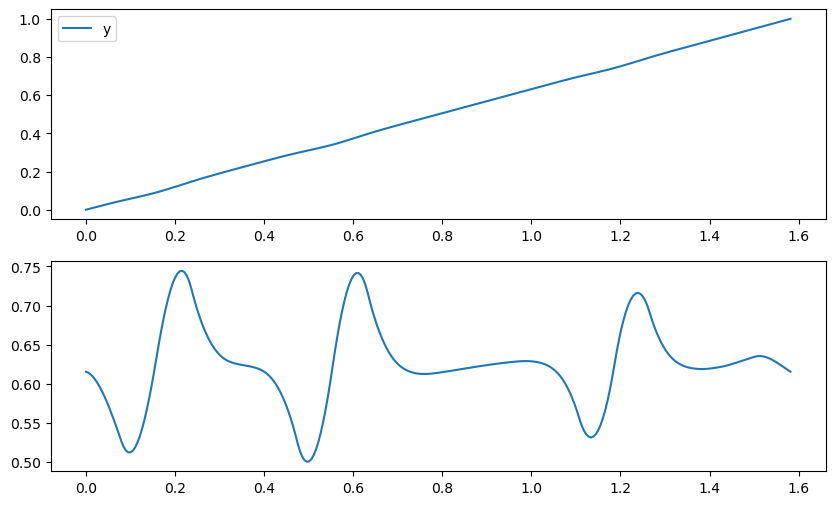

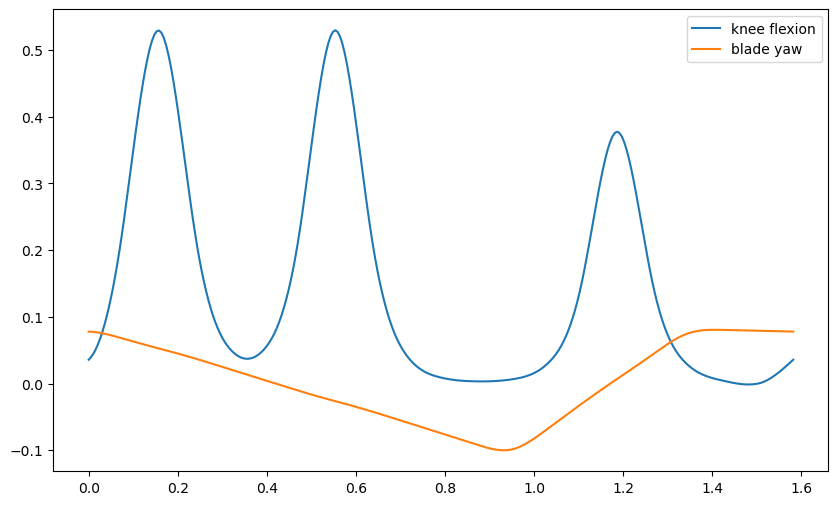

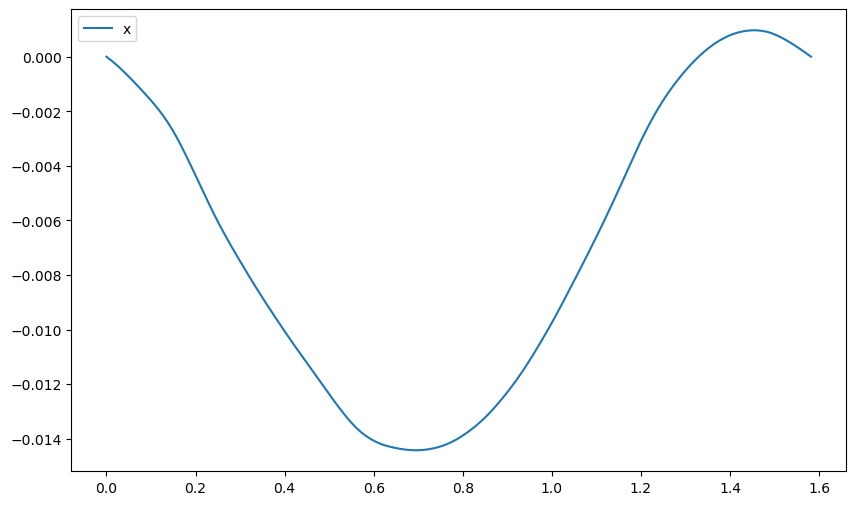

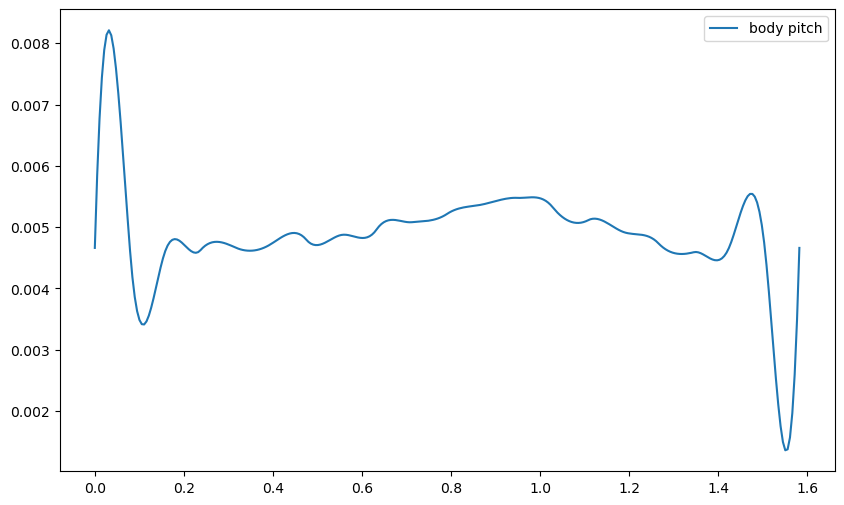

In [7]:
x_traj = dircol.ReconstructStateTrajectory(result)

builder2 = DiagramBuilder()

plant2 = builder2.AddSystem(MultibodyPlant(time_step=0.0))
scene_graph2 = builder2.AddSystem(SceneGraph())
parser = Parser(plant2, scene_graph2)
ConfigureParser(parser)
parser.AddModelsFromString(model_urdf, "urdf")
plant2.Finalize()

pos_to_pose = builder2.AddSystem(
    MultibodyPositionToGeometryPose(plant2, input_multibody_state=True)
)
#builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
builder2.Connect(plant2.GetOutputPort("state"), pos_to_pose.get_input_port(0))
builder2.Connect(
    pos_to_pose.get_output_port(),
    scene_graph2.get_source_pose_port(plant2.get_source_id()),
)

visualizer = MeshcatVisualizer.AddToBuilder(builder2, scene_graph2, meshcat)

diagram2 = builder2.Build()
context2 = diagram2.CreateDefaultContext()
diagram2.ForcedPublish(context2)



visualizer.StartRecording()
for t in np.hstack(
    (
        np.arange(x_traj.start_time(), x_traj.end_time(), 1.0 / 32.0),
        x_traj.end_time(),
    )
):
    context2.SetTime(t)
    context2.SetContinuousState(x_traj.value(t))
    diagram2.ForcedPublish(context2)

visualizer.StopRecording()
visualizer.PublishRecording()
#simulator.AdvanceTo(x_trajectory.end_time())
#visualizer.PublishRecording()




from matplotlib import pyplot as plt


u_traj = dircol.ReconstructInputTrajectory(result)
ts = np.linspace(x_traj.start_time(), x_traj.end_time(), 301)

xs = x_traj.vector_values(ts)
us = u_traj.vector_values(ts)


fig, ax = plt.subplots(3, 1, figsize=(10, 6))
ax[0].plot(ts, us[0, :], label="reaction force")
ax[0].legend()
ax[1].plot(ts, us[1, :], label="backwards friction")
ax[1].legend()
ax[2].plot(ts, us[2, :], label="sideways friction")
ax[2].legend()



fig, ax = plt.subplots(5, 1, figsize=(10, 6))
ax[0].plot(ts, us[3, :], label="ankle stabilization")
ax[0].legend()
ax[1].plot(ts, us[4, :], label="knee")
ax[1].legend()
ax[2].plot(ts, us[5, :], label="quad")
ax[2].legend()
ax[3].plot(ts, us[6, :], label="hip extension")
ax[3].legend()
ax[4].plot(ts, us[7, :], label="hip rotation")
ax[4].legend()




fig, ax = plt.subplots(3, 1, figsize=(10, 6))
ax[0].plot(ts, xs[X, :], label="x")
ax[0].legend()
ax[1].plot(ts, xs[Y, :], label="y")
ax[1].legend()
ax[2].plot(ts, xs[Z, :], label="z")
ax[2].legend()



fig, ax = plt.subplots(3, 1, figsize=(10, 6))
ax[0].plot(ts, xs[X_DOT, :], label="x'")
ax[0].legend()
ax[1].plot(ts, xs[Y_DOT, :], label="y'")
ax[1].legend()
ax[2].plot(ts, xs[Z_DOT, :], label="z'")
ax[2].legend()



fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(ts, xs[Y, :], label="y")
ax[0].legend()
ax[1].plot(ts, xs[Y_DOT, :], label="y'")



fig, ax = plt.subplots(1, 1, figsize=(10, 6))
K = xs[KNEE, :]
Qr = xs[0, :]
Qi = xs[1, :]
Qj = xs[2, :]
Qk = xs[3, :]

#YAW = np.arccos(1 - 2*(Qi**2 + Qk**2))
YAW = np.arcsin(2*(Qi*Qj + Qk*Qr))
#print(1 - 2*(Qi**2 + Qk**2))

ax.plot(ts, K, label="knee flexion")
ax.plot(ts, YAW, label="blade yaw")
ax.legend()

fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(ts, xs[X, :], label = "x")
ax.legend()

fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(ts, xs[ANKLE, :] + xs[KNEE, :] + xs[QUAD, :], label = "body pitch")
ax.legend()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6a0b295f-cf18-4bda-b186-efbdae810fad' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>